In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GP:
  def __init__(self, dim, device="cuda" ):
    self.beta = 10.0
    self.dim = dim
    self.device = device

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt).reshape(-1,self.dim)
    self.yt = torch.tensor(yt)
    N = len(xt)

    # to gpu
    self.xt = self.xt.to(self.device)
    self.yt = self.yt.to(self.device)

    # カーネル行列を定義
    self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N, device=self.device)/self.beta
    self.K_inv = torch.inverse( self.K )
  
  def predict( self, x ):
    x = torch.tensor(x, device=self.device).reshape(-1,self.dim)

    kx = self.cov( x, self.xt )
    k = self.cov( x, x) + 1.0/self.beta

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()

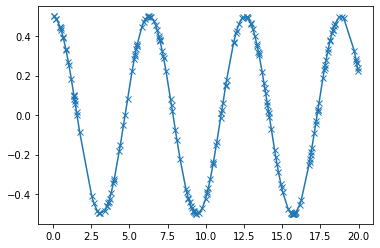

In [13]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

In [22]:
gp = GP(1, "cpu")
gp.learn( xt.reshape((-1,1)), yt )

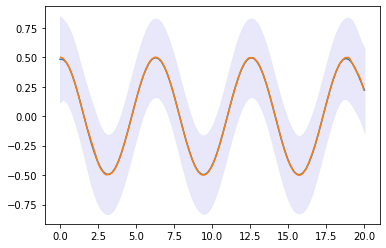

In [23]:
x = np.linspace( 0,20,100 )

mus, sigmas = gp.predict( x.reshape(-1,1) )
plt.plot( x, mus )

y_max = mus + np.sqrt(sigmas.flatten())
y_min = mus - np.sqrt(sigmas.flatten())

plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
plt.plot(xt, yt)
plt.show()